### Tracking PQs topics

This notebook explores ways of tracking and analysing the topics that are the subject of PQs by MPs and Peers

In [179]:
import requests
import json
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import os
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import re

#### Import and clean up data

We'll import some data on MPs, so that - if we want to - we can find out more about who is asking about what. Then we'll import all PQs (unanswered & answered). 

We clean up the PQs data, too. 

In [180]:
active_p = pd.read_csv('active_members.csv')
former_p = pd.read_csv('former_members.csv')

all_p = pd.concat([active_p, former_p])
all_p = all_p[['id', 'nameListAs', 'gender', 'latestPartyabbreviation']]

id_party_dict = dict(zip(all_p.id, all_p.latestPartyabbreviation))

In [181]:
wpqs = pd.read_csv('tmp/ua_pqs.csv')
wpqs['dateTabled'] = pd.to_datetime(wpqs.dateTabled)
wpqs['heading'] = wpqs.heading.fillna('')
# wpqs = wpqs[['id', 'askingMemberId', 'askingMember', 'house', 'dateTabled', 'questionText', 'answeringBodyName', 'heading']]

# Populate a column with party appreviation in the WPQs database
wpqs['latestPartyabbreviation'] = wpqs.askingMemberId.progress_apply(lambda x: id_party_dict[x] if x in id_party_dict.keys() else 'n/a')

# Make some of the string fields lower case to improve comparability and searchability
wpqs['heading'] = wpqs.heading.progress_apply(lambda x: x.lower())
wpqs['questionText'] = wpqs.questionText.progress_apply(lambda x: x.lower())

# Sometime the heading is a generic topic, other times it's specified by a ":" symbol. We'll extract this into a 'topic' column.
wpqs['topic'] = wpqs.heading.progress_apply(lambda x: x.split(':')[0])

wpqs['year_month'] = wpqs.dateTabled.dt.to_period('M')

100%|██████████████████████████████████████████████████████████████████| 385107/385107 [00:00<00:00, 1334860.40it/s]


In [182]:
# Cleaning up the question text

# Aim: to get the bit of text after the 'to ask the secretary of state for blah blah, if...'

def question_cleaner(question):
    q = re.sub(r',(?=\S)|:', ', ', question)
    q = q.replace("to ask her majesty's government ", "to ask her majesty's government, ").replace("to ask her majesty’s government ", "to ask her majesty's government, ")
    q = q.replace(', and', ' and').replace('foreign, commonwealth and development affairs', 'foreign commonwealth and development affairs').replace('digital, culture, media', 'digital culture media').replace('business, energy and industrial', 'business energy and industrial')
    q = q.replace('levelling up, housing and', 'levelling up housing and').replace('environment, food and rural affairs', 'environment food and rural affairs').replace('culture, media and sport', 'culture media and sport').replace('business, innovation and skills', 'business innovation and skills')
    q = q.replace('digital, culture, media and sport', 'digital culture media and sport')
    q = q.replace('housing, communities and local government', 'housing communities and local government')
    q = q.replace(', representing the church commissioners', ' representing the church commissioners, ') 
    q = q.replace('to ask the chairman of committees ', 'to ask the chairman of committees, ')
    q = q.replace('to ask the leader of the house ', 'to ask the leader of the house, ')
    q = q.replace("to ask her majesty’s government", "to ask her majesty's government, ")
    q = q.replace("to ask the senior deputy speaker ", "to ask the senior deputy speaker, ")
    q = q.replace("her majesty's government ", "her majesty's government, ")
    q = q.replace("to ask the secretary of state for education ", "to ask the secretary of state for education, ")
    q = q.replace("to ask the secretary of state for defence ", "to ask the secretary of state for defence, ")
    q = q.replace("to ask the secretary of state for work and pensions ", "to ask the secretary of state for work and pensions, ")
    q = q.replace("to ask the secretary of state for environment food and rural affairs ", "to ask the secretary of state for environment food and rural affairs, ")
    q = q.replace("to ask the secretary of state for health ", "to ask the secretary of state for health, ")
    q = q.replace("foreign and commonwealth affairs ", "foreign and commonwealth affairs, ")
    q = q.replace("foreign commonwealth and development affairs ", "foreign commonwealth and development affairs, ")
    q = q.replace("the senior deputy speaker ", "the senior deputy speaker, ")
    q = q.replace("secretary of state for the home department,", "secretary of state for the home department, ")
    q = q.replace("to ask mr chancellor of the exchequer ", "to ask mr chancellor of the exchequer, ")
    q = q.replace("to ask the minister of the cabinet office ", "to ask the minister of the cabinet office, ")
    q = q.replace("to ask the minister for the cabinet office ", "to ask the minister for the cabinet office, ")
    q = q.replace("to ask the secretary of state for communities and local government ", "to ask the secretary of state for communities and local government, ")
    q = ' '.join(q.split(', ')[1:])
    cleaned_question = q
    return cleaned_question

wpqs['cleanedQuestion'] = wpqs.questionText.progress_apply(lambda x: question_cleaner(x))

100%|███████████████████████████████████████████████████████████████████| 385107/385107 [00:03<00:00, 125461.55it/s]


In [183]:
# def question_cleaner(question):
#     q = re.sub(r',(?=\S)|:', ', ', question)
#     q = q.replace("to ask her majesty's government ", "to ask her majesty's government, ").replace("to ask her majesty’s government ", "to ask her majesty's government, ")
#     q = q.replace(', and', ' and').replace('foreign, commonwealth and development affairs', 'foreign commonwealth and development affairs').replace('digital, culture, media', 'digital culture media').replace('business, energy and industrial', 'business energy and industrial')
#     q = q.replace('levelling up, housing and', 'levelling up housing and').replace('environment, food and rural affairs', 'environment food and rural affairs').replace('culture, media and sport', 'culture media and sport').replace('business, innovation and skills', 'business innovation and skills')
#     q = q.replace('digital, culture, media and sport', 'digital culture media and sport')
#     q = q.replace('housing, communities and local government', 'housing communities and local government')
#     q = q.replace(', representing the church commissioners', ' representing the church commissioners, ')
#     q = q.replace('to ask the chairman of committees ', 'to ask the chairman of committees, ')
#     q = q.replace('to ask the leader of the house ', 'to ask the leader of the house, ')
#     q = q.replace("to ask her majesty’s government", "to ask her majesty's government, ")
#     q = q.replace("to ask the senior deputy speaker ", "to ask the senior deputy speaker, ")
#     q = q.replace("her majesty's government ", "her majesty's government, ")
#     q = q.replace("to ask the secretary of state for education ", "to ask the secretary of state for education, ")
#     q = q.replace("to ask the secretary of state for defence ", "to ask the secretary of state for defence, ")
#     q = q.replace("to ask the secretary of state for work and pensions ", "to ask the secretary of state for work and pensions, ")
#     q = q.replace("to ask the secretary of state for environment food and rural affairs ", "to ask the secretary of state for environment food and rural affairs, ")
#     q = q.replace("to ask the secretary of state for health ", "to ask the secretary of state for health, ")
#     q = q.replace("foreign and commonwealth affairs ", "foreign and commonwealth affairs, ")
#     q = q.replace("foreign commonwealth and development affairs ", "foreign commonwealth and development affairs, ")
#     q = q.replace("the senior deputy speaker ", "the senior deputy speaker, ")
#     q = q.replace("secretary of state for the home department,", "secretary of state for the home department, ")
#     q = q.replace("to ask mr chancellor of the exchequer ", "to ask mr chancellor of the exchequer, ")
#     q = q.replace("to ask the minister of the cabinet office ", "to ask the minister of the cabinet office, ")
#     q = q.replace("to ask the minister for the cabinet office ", "to ask the minister for the cabinet office, ")
#     q = q.replace("to ask the secretary of state for communities and local government ", "to ask the secretary of state for communities and local government, ")
#     q = ' '.join(q.split(', ')[:1]) # CHANGE ME TO GET THE SUBSTANCE OF THE QUESTION
#     cleaned_question = q
#     return cleaned_question

# wpqs['dept'] = wpqs.questionText.progress_apply(lambda x: question_cleaner(x))

In [191]:
# len(wpqs.dept.unique().tolist())

In [219]:
wpqs[wpqs.dateTabled == '2022-02-28']

,id,askingMemberId,askingMember,house,memberHasInterest,dateTabled,dateForAnswer,uin,questionText,answeringBodyId,answeringBodyName,heading,latestPartyabbreviation,topic,year_month,cleanedQuestion
379686,1436237,4836,NaN,Commons,False,2022-02-28,2022-02-28T00:00:00,905751,to ask the secretary of state for the home dep...,1,Home Office,knives: crime,Con,knives,2022-02,what recent progress her department has made ...
379687,1436236,4602,NaN,Commons,False,2022-02-28,2022-02-28T00:00:00,905750,to ask the secretary of state for the home dep...,1,Home Office,offences against children,LD,offences against children,2022-02,what steps she is taking to ensure that her d...
379688,1436235,4829,NaN,Commons,False,2022-02-28,2022-02-28T00:00:00,905749,to ask the secretary of state for the home dep...,1,Home Office,metropolitan police: stop and search,Lab,metropolitan police,2022-02,what recent assessment she has made of the ef...
379689,1436234,3953,NaN,Commons,False,2022-02-28,2022-02-28T00:00:00,905746,to ask the secretary of state for the home dep...,1,Home Office,theft,Con,theft,2022-02,what recent progress her department has made ...
379692,1436233,4084,NaN,Commons,False,2022-02-28,2022-02-28T00:00:00,905745,to ask the secretary of state for the home dep...,1,Home Office,cybercrime,Con,cybercrime,2022-02,what estimate she has made of the proportion ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385102,1436817,4124,NaN,Commons,False,2022-02-28,2022-03-02T00:00:00,131173,"to ask the secretary of state for education, w...",60,Department for Education,,Lab,,2022-02,what steps he is taking to help ensure that a...
385103,1436814,4124,NaN,Commons,False,2022-02-28,2022-03-02T00:00:00,131170,"to ask the secretary of state for business, en...",201,"Department for Business, Energy and Industrial...",,Lab,,2022-02,whether he plans to make the 105 power cut pho...
385104,1436657,1512,NaN,Commons,False,2022-02-28,2022-03-02T00:00:00,131123,"to ask the minister for the cabinet office, if...",53,Cabinet Office,,Con,,2022-02,if he will confirm that (a) sir robert francis...
385105,1436775,1506,NaN,Commons,False,2022-02-28,2022-03-03T00:00:00,131121,to ask the secretary of state for health and s...,17,Department of Health and Social Care,,Lab,,2022-02,and social care what guidance his department i...


#### Exploratory analysis

Let's make a word cloud of a particular day's PQs. 

In [193]:
from wordcloud import WordCloud

In [228]:
# Set the date here

date = '2022-01-28'

In [229]:
# Filter out the Lords, whose questions take a different format
wpqs_sel = wpqs[wpqs.house == 'Commons']

# Make a long string of all the questions. 

# Each question starts in the form "To ask the secretary of state for X, what [question text]". We'll get the bit after the "what, "
question_text = wpqs_sel[wpqs_sel.dateTabled == date].cleanedQuestion.tolist()
# question_text = wpqs_sel[wpqs_sel.year_month == date].cleanedQuestion.tolist()
    
# Clean out a few meaningless words that appear over and over
question_text = [x.replace('.', ' ').replace(' take ', ' ').replace('agencies remove', ' ').replace(' department ', ' ').replace('publish', '').replace(' government ', ' ').replace('pursuant', '').replace('question', '').replace('answer', '').replace('reference', '').replace(' effect ', ' ').replace(' make ', ' ').replace(' ensure ', ' ').replace('steps', '').replace(' assessment ', ' ').replace('taking', '').replace('made', '').replace('will', '') for x in question_text]
question_text = [x.replace('many', '').replace('whether', '').replace('(b)', '').replace('(a)', '') for x in question_text]
question_text = [x.replace('people', '').replace(' support ', ' ').replace(' s ', '').replace(' plans ', ' ').replace(' plan ', ' ') for x in question_text]
question_text = [x.replace(' application ', ' ').replace(' applications ', ' ').replace(' level ', ' ').replace(' help ', ' ').replace(' administration ', ' ').replace(' discussion ', ' ').replace(' service ', '').replace('communities', '').replace(' discussions ', '').replace(' impact ', '').replace('january', '').replace('february', '').replace(' uk ', ' ').replace('recent', '').replace(' estimate ', ' ').replace(' number ', ' ').replace(' c ', '') for x in question_text]
question_text = [x.replace('department', '').replace(' proportion ', ' ').replace(' department ', ' ').replace(' england ', ' ').replace('potential merits', ' ').replace(' national ', ' ').replace(' may ', ' ').replace(' statement ', ' ').replace(' year ', ' ').replace('(c)', ' ') for x in question_text]
question_text = [x.replace(' april ', ' ') for x in question_text]

long_string = ', '.join(question_text)

In [230]:
wordcloud = WordCloud(
    background_color='white', 
    max_words = 5000, 
    contour_width=3, 
    contour_color='steelblue', 
    width = 1500, 
    height=750
)


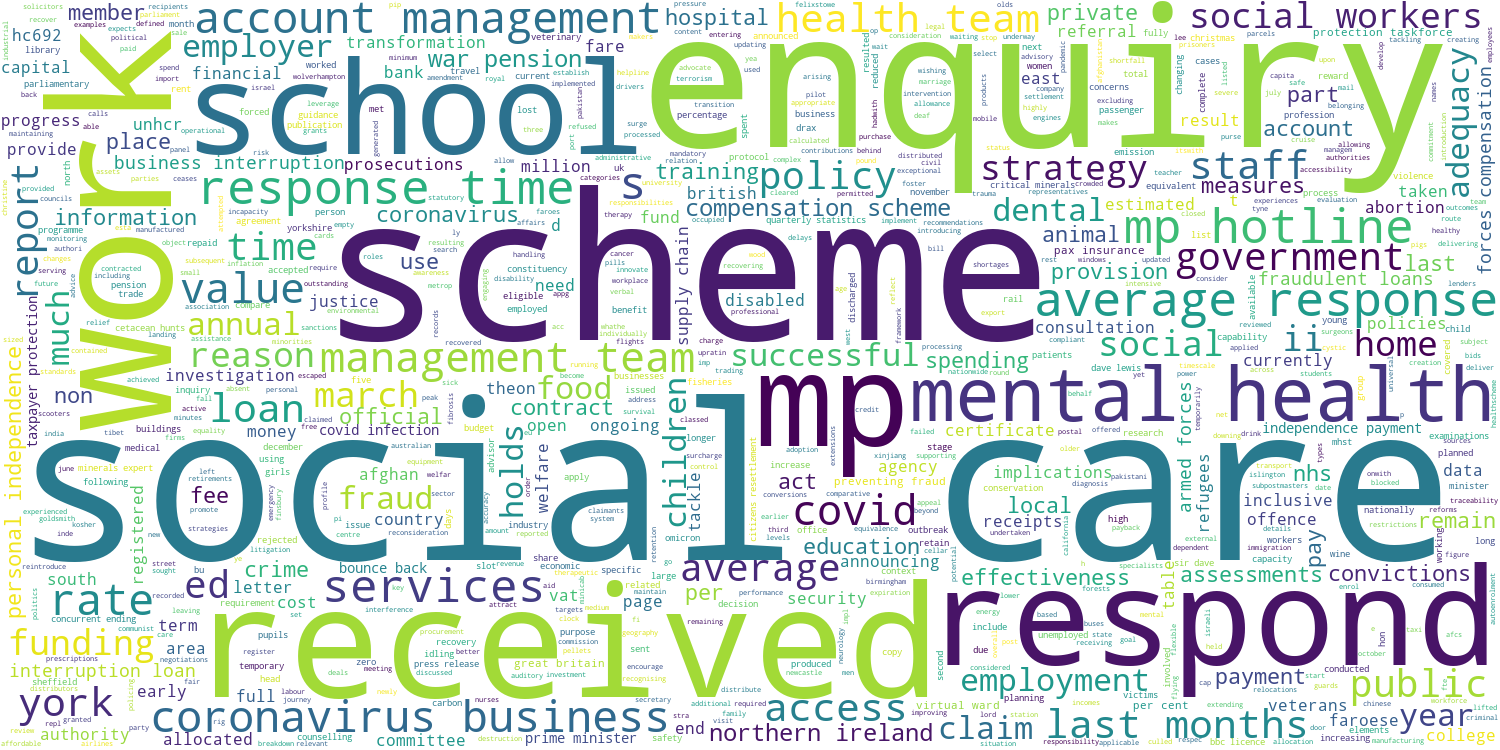

In [231]:
wordcloud.generate(long_string)
wordcloud.to_image()

## SpaCy
We're going to try to create a text classifier using Spacy to tag each PQ with a topic keyword. We want a mutli-classifier, i.e. PQs can have more than one tag. 

### Step one: tokenisation

In [271]:
from spacy.lang.en import English, stop_words
import en_core_web_sm
import spacy
from spacy import displacy

nlp = en_core_web_sm.load()
spacy_stopwords = stop_words.STOP_WORDS
print("Number of stop words: {d}".format(d = len(spacy_stopwords)))

Number of stop words: 326


In [289]:
txt = wpqs.iloc[-55].questionText
txt = nlp(txt)

In [290]:
entities = [(i, i.label_, i.label) for i in txt.ents]

In [291]:
entities

[(england, 'GPE', 384), (every year, 'DATE', 391)]

In [292]:
txt

to ask the secretary of state for justice, if he will (a) list the spending programmes his department devolves for administration to local government in england and other local spending bodies and (b) specify the value for each programme for every year fo

In [293]:
wpqs.iloc[-55]

id                                                                   1436627
askingMemberId                                                          1171
askingMember                                                             NaN
house                                                                Commons
memberHasInterest                                                      False
dateTabled                                               2022-02-28 00:00:00
dateForAnswer                                            2022-03-02T00:00:00
uin                                                                   131069
questionText               to ask the secretary of state for justice, if ...
answeringBodyId                                                           54
answeringBodyName                                        Ministry of Justice
heading                                                                     
latestPartyabbreviation                                                  Lab

In [302]:
def get_wpqs_by_date(tabledWhenFrom, tabledWhenTo):
    """
    Download WPQs tabled between a given range (recommended not to specify longer than 1 month). Dates should be in the format 'yyyy-mm-dd'.
    :param: tabledWhenFrom str 'yyyy-mm-dd'
    :param: tabledWhenTo str 'yyyy-mm-dd'
    :param: answered bool default None. If True, the function only downloads answered PQs. If False, only unanswered. If None, all are downloaded.  
    :return: a list of WQPs expressed in dictionaries. 
    """
    url = 'https://writtenquestions-api.parliament.uk/api/writtenquestions/questions'

    params = {
        'tabledWhenFrom': tabledWhenFrom,
        'tabledWhenTo': tabledWhenTo,
        'take':1000000,
        'answered': 'Any'
        }

    headers = {'Accept': 'text/plain'}

    r = requests.get(url=url, params = params, headers=headers)
    data = [x['value'] for x in r.json()['results']]
    return data

In [303]:
get_wpqs_by_date(tabledWhenFrom = '2022-02-28', tabledWhenTo = '2022-03-01')

[{'id': 1436237,
  'askingMemberId': 4836,
  'askingMember': None,
  'house': 'Commons',
  'memberHasInterest': False,
  'dateTabled': '2022-02-28T00:00:00',
  'dateForAnswer': '2022-02-28T00:00:00',
  'uin': '905751',
  'questionText': 'To ask the Secretary of State for the Home Department, what recent progress her Department has made on reducing the level of knife crime.',
  'answeringBodyId': 1,
  'answeringBodyName': 'Home Office',
  'isWithdrawn': False,
  'isNamedDay': True,
  'groupedQuestions': [],
  'answerIsHolding': False,
  'answerIsCorrection': False,
  'answeringMemberId': 4495,
  'answeringMember': None,
  'correctingMemberId': None,
  'correctingMember': None,
  'dateAnswered': '2022-02-28T00:00:00',
  'answerText': 'The Government is committed to reducing knife crime, this why we have invested £130.5 million over the last year to tackle serious violence.This includes £35.5 million for Violence Reduction Units which draw key partners together to address the root cause..